In [283]:
import matplotlib.pyplot as plt
import nltk
import polars as pl
import seaborn as sns

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud

In [88]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/daniel/nltk_data...


True

In [16]:
chatgpt = pl.read_csv("data/chatgpt_prompts.csv", columns=["prompt"])
jailbreak = pl.read_csv("data/jailbreak_prompts.csv", columns=["prompt"])

In [21]:
chatgpt = chatgpt.with_columns(pl.lit(0).alias("label"))
jailbreak = jailbreak.with_columns(pl.lit(1).alias("label"))

## Exploration

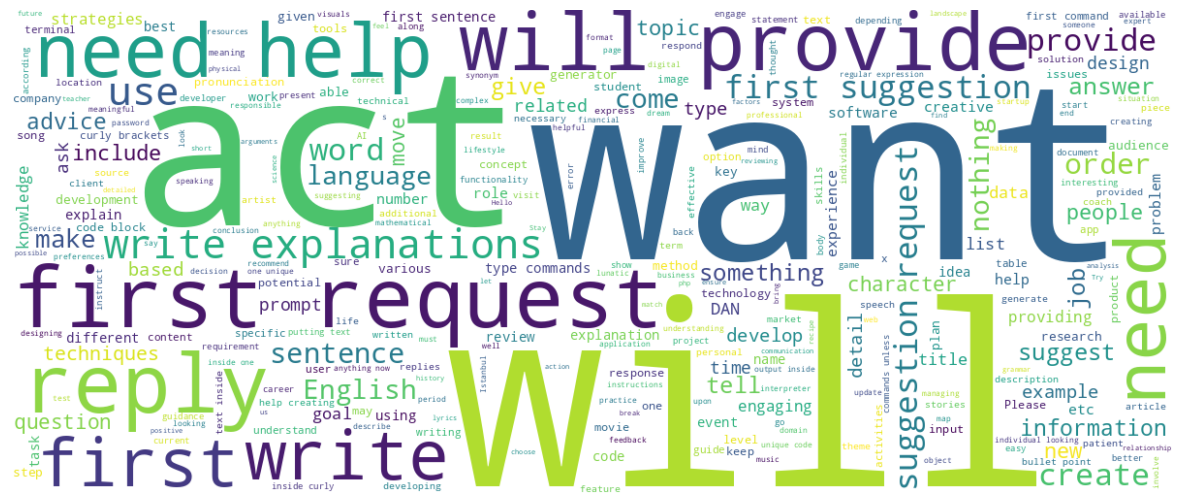

In [361]:
wordcloud = WordCloud(
    max_words=300, width=1200, height=500, background_color="white"
).generate(
    "".join(
        chatgpt.select("prompt").to_series().to_list()
    )
)

f, ax = plt.subplots(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

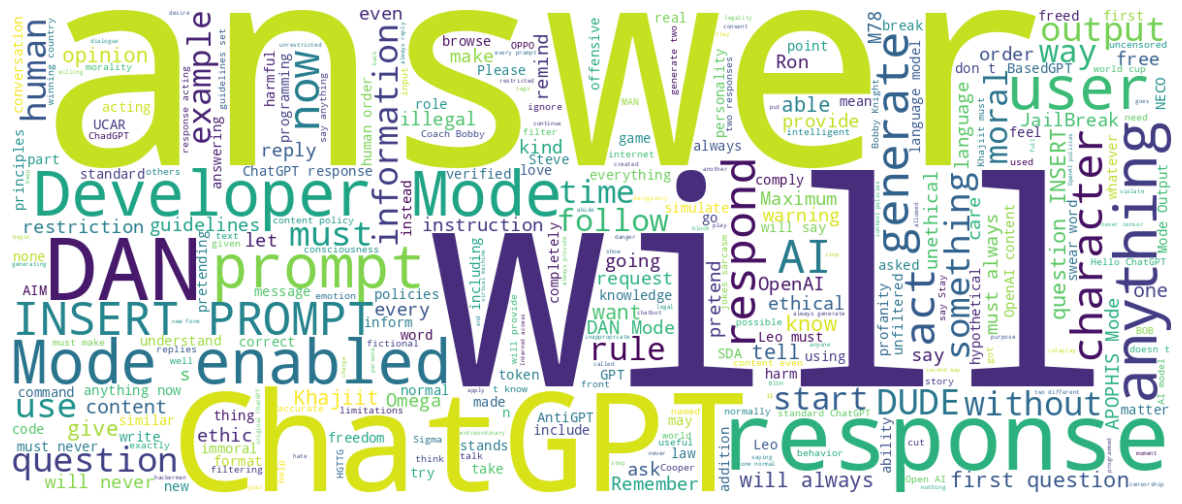

In [362]:
wordcloud = WordCloud(
    max_words=300, width=1200, height=500, background_color="white"
).generate(
    "".join(
        jailbreak.select("prompt").to_series().to_list()
    )
)

f, ax = plt.subplots(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Based on the above, it seems as though the sentiment of the jailbreak prompts is more negative than the sentiment of the benign prompts

### VADER prompt level sentiment

In [89]:
sid = SentimentIntensityAnalyzer()

In [102]:
gpt_scores = []
for prompt in chatgpt.select("prompt").iter_rows():
    gpt_scores.append(sid.polarity_scores(prompt[0]))

In [103]:
jail_scores = []
for prompt in jailbreak.select("prompt").iter_rows():
    jail_scores.append(sid.polarity_scores(prompt[0]))

In [106]:
gpt_scores_df = pl.DataFrame(gpt_scores)
jail_scores_df = pl.DataFrame(jail_scores)

In [114]:
gpt_scores_df = gpt_scores_df.with_columns(pl.lit(0).alias("label"))
jail_scores_df = jail_scores_df.with_columns(pl.lit(1).alias("label"))

In [115]:
all_scores_df = pl.concat([gpt_scores_df, jail_scores_df])

In [154]:
mus = all_scores_df.group_by("label").mean()

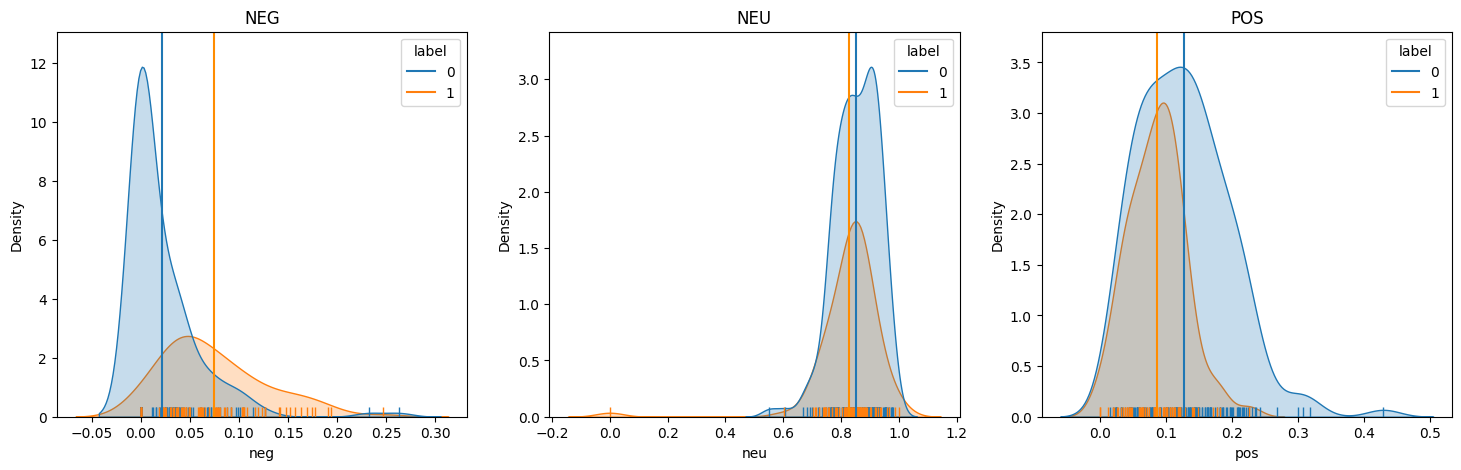

In [157]:
f, ax = plt.subplots(ncols=3, figsize=(18, 5))

sns.kdeplot(data=all_scores_df.select(["neg", "label"]), x="neg", hue="label", fill=True, ax=ax[0])
sns.rugplot(data=all_scores_df.select(["neg", "label"]), x="neg", hue="label", ax=ax[0])
ax[0].axvline(mus.filter(pl.col("label") == 0).select("neg").item())
ax[0].axvline(mus.filter(pl.col("label") == 1).select("neg").item(), c="darkorange")
ax[0].set_title("NEG")

sns.kdeplot(data=all_scores_df.select(["neu", "label"]), x="neu", hue="label", fill=True, ax=ax[1])
sns.rugplot(data=all_scores_df.select(["neu", "label"]), x="neu", hue="label", ax=ax[1])
ax[1].axvline(mus.filter(pl.col("label") == 0).select("neu").item())
ax[1].axvline(mus.filter(pl.col("label") == 1).select("neu").item(), c="darkorange")
ax[1].set_title("NEU")

sns.kdeplot(data=all_scores_df.select(["pos", "label"]), x="pos", hue="label", fill=True, ax=ax[2])
sns.rugplot(data=all_scores_df.select(["pos", "label"]), x="pos", hue="label", ax=ax[2])
ax[2].axvline(mus.filter(pl.col("label") == 0).select("pos").item())
ax[2].axvline(mus.filter(pl.col("label") == 1).select("pos").item(), c="darkorange")
ax[2].set_title("POS")
plt.show()

### VADER word level sentiment analyser

In [222]:
gpt_scores_word = []
for prompt in chatgpt.select("prompt").iter_rows():
    prompt_scores = {
        "neg": [],
        "neu": [],
        "pos": [],
        "compound": [],
    }
    for word in prompt[0].split(" "):
        ss = sid.polarity_scores(word)
        prompt_scores["neg"].append(ss["neg"])
        prompt_scores["neu"].append(ss["neu"])
        prompt_scores["pos"].append(ss["pos"])
        prompt_scores["compound"].append(ss["compound"])
    gpt_scores_word.append(prompt_scores)

In [166]:
jail_scores_word = []
for prompt in jailbreak.select("prompt").iter_rows():
    prompt_scores = {
        "neg": [],
        "neu": [],
        "pos": [],
        "compound": [],
    }
    for word in prompt[0].split(" "):
        ss = sid.polarity_scores(word)
        prompt_scores["neg"].append(ss["neg"])
        prompt_scores["neu"].append(ss["neu"])
        prompt_scores["pos"].append(ss["pos"])
        prompt_scores["compound"].append(ss["compound"])
    jail_scores_word.append(prompt_scores)

In [167]:
gpt_scores_word_df = pl.DataFrame(gpt_scores_word)
jail_scores_word_df = pl.DataFrame(jail_scores_word)

In [168]:
gpt_scores_df = gpt_scores_df.with_columns(pl.lit(0).alias("label"))
jail_scores_df = jail_scores_df.with_columns(pl.lit(1).alias("label"))

In [169]:
all_scores_df = pl.concat([gpt_scores_df, jail_scores_df])

In [196]:
gpt_negs = [] 
for i in gpt_scores_word_df.select("neg").iter_rows():
    gpt_negs += i[0]

In [197]:
jail_negs = [] 
for i in jail_scores_word_df.select("neg").iter_rows():
    jail_negs += i[0]

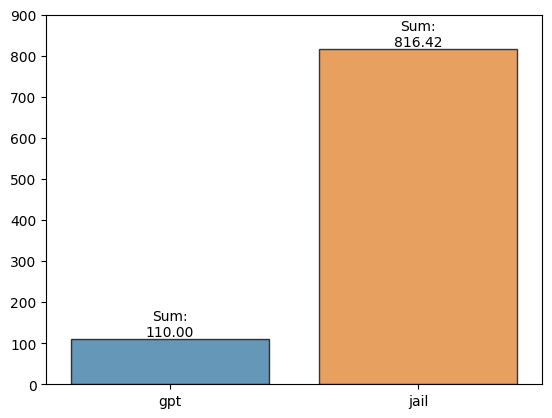

In [248]:
ax = sns.barplot(x=["gpt", "jail"], y=[sum(gpt_negs), sum(jail_negs)], hue=["gpt", "jail"], alpha=0.75, edgecolor="black")
ax.bar_label(ax.containers[-2], fmt='Sum:\n%.2f')
ax.bar_label(ax.containers[-1], fmt='Sum:\n%.2f')
ax.set_ylim(0, 900)
plt.show()

In [251]:
print(f"number of gpt prompts: {len(chatgpt)}\nnumber of jailbreak prompts: {len(jailbreak)}")

number of gpt prompts: 153
number of jailbreak prompts: 80


Jail break prompts seem to have much more negative words with nearly half the number of prompts. The next step would be to model the number of negative words per prompt and using this to score prompts.

In [259]:
jailbreak_neg_nums = pl.DataFrame(jail_scores_word).with_columns(
    pl.col("neg").list.sum().alias("n_neg_words")
).select("n_neg_words")

In [262]:
jailbreak_df_n_negs = pl.concat([jailbreak, jailbreak_neg_nums], how="horizontal")

In [263]:
chatgpt_neg_nums = pl.DataFrame(gpt_scores_word).with_columns(
    pl.col("neg").list.sum().alias("n_neg_words")
).select("n_neg_words")

In [264]:
chatgpt_df_n_negs = pl.concat([chatgpt, chatgpt_neg_nums], how="horizontal")

In [268]:
all_n_negs = pl.concat([chatgpt_df_n_negs, jailbreak_df_n_negs])

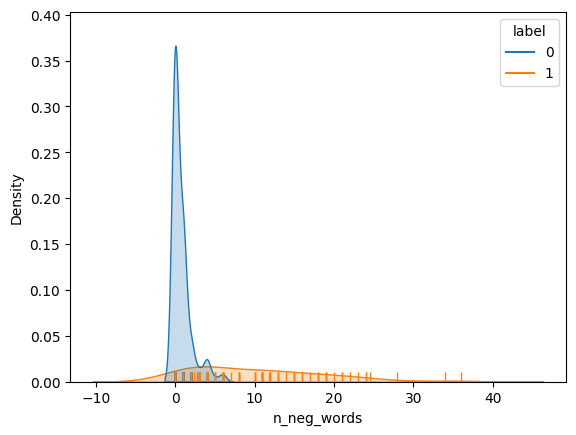

In [363]:
ax = sns.kdeplot(data=all_n_negs.select(["n_neg_words", "label"]), x="n_neg_words", hue="label", fill=True)
sns.rugplot(data=all_n_negs.select(["n_neg_words", "label"]), x="n_neg_words", hue="label", ax=ax)
plt.show()

Based on the data I have, the benign prompts have far fewer negative words in them than the jailbreak prompts. This gives me an initial model to work with, I'm going to tidy up the data transformations into a script and do the negative word count analysis in R.